In [1]:
import osmnx as ox
import pandas as pd
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.patheffects as PathEffects
from adjustText import adjust_text

In [2]:
G = ox.graph_from_place('Olsztyn, Poland', network_type='walk')
nodes, edges = ox.graph_to_gdfs(G)

In [3]:
tags = {
    'amenity': ['school', 'bus_station'],
    'shop': True,
    'leisure': ['park']
}
pois = ox.features.features_from_place('Olsztyn, Poland', tags)

In [4]:
nodes = nodes.to_crs(2180)
pois = pois.to_crs(2180)

def count_poi_around_node(node_gdf, poi_gdf, buffer=300, filter_column=None, filter_value=None):
    if filter_column:
        if filter_value:
            selected = poi_gdf[poi_gdf[filter_column] == filter_value]
        else:
            selected = poi_gdf[poi_gdf[filter_column].notnull()]
    else:
        selected = poi_gdf
    counts = []
    for geom in node_gdf.geometry:
        counts.append(selected[selected.distance(geom) < buffer].shape[0])
    return counts

nodes['schools_300m'] = count_poi_around_node(nodes, pois, 300, 'amenity', 'school')
nodes['shops_300m'] = count_poi_around_node(nodes, pois, 300, 'shop')

nodes['busstations_300m'] = count_poi_around_node(nodes, pois, 300, 'amenity', 'bus_station')
nodes['parks_300m'] = count_poi_around_node(nodes, pois, 300, 'leisure', 'park')

In [5]:
nodes['high_pedestrian'] = (
    (nodes['schools_300m'] > 1) | 
    (nodes['shops_300m'] > 3) | 
    (nodes['busstations_300m'] > 1)
).astype(int)

In [6]:
feature_cols = ['schools_300m', 'shops_300m', 'busstations_300m', 'parks_300m']
X = nodes[feature_cols].fillna(0)
y = nodes['high_pedestrian']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [9]:
y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
classify_report = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))
print(conf_matrix)

              precision    recall  f1-score   support

           0       0.98      0.95      0.97      1330
           1       0.98      0.99      0.99      3133

    accuracy                           0.98      4463
   macro avg       0.98      0.97      0.98      4463
weighted avg       0.98      0.98      0.98      4463

[[1266   64]
 [  23 3110]]


<Axes: >

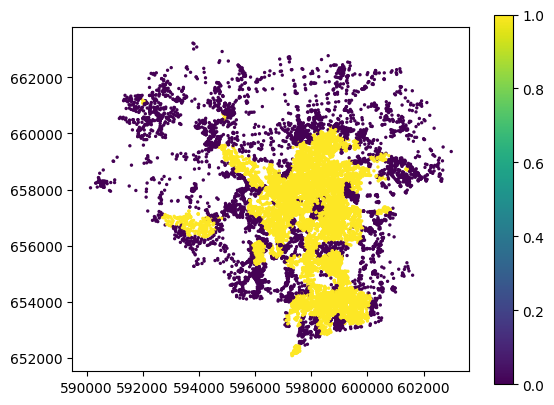

In [10]:
nodes['model_pred'] = model.predict(X)
nodes.plot(column='model_pred', markersize=2, legend=True)

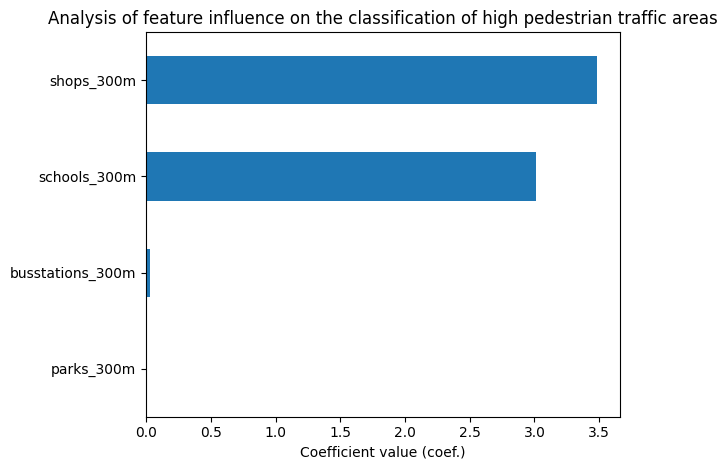

In [11]:
coeffs = pd.Series(model.coef_[0], index=feature_cols)
coeffs.sort_values().plot(kind='barh')
plt.title('Analysis of feature influence on the classification of high pedestrian traffic areas')
plt.xlabel('Coefficient value (coef.)')
plt.tight_layout()
plt.show()

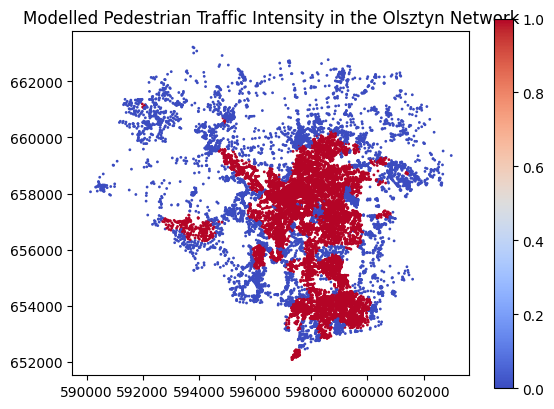

In [12]:
nodes.plot(column='model_pred', markersize=1, cmap='coolwarm', legend=True)
plt.title('Modelled Pedestrian Traffic Intensity in the Olsztyn Network')
plt.show()

In [13]:
tags = {"place": ["suburb", "neighbourhood"]}
districts = ox.features.features_from_place("Olsztyn, Poland", tags)
print(districts[['name']])

                                            name
element id                                      
node    31520902                       Redykajny
        31524385                         Gutkowo
        767869922                   Grunwaldzkie
        767869929    Osiedle nad Jeziorem Długim
        767869933                    Śródmieście
        767869945               Wojska Polskiego
        767869947              Osiedle Mazurskie
        767870023                       Kormoran
        767870046                         Jaroty
        767870048                     Pojezierze
        767870063          Osiedle Kętrzyńskiego
        767870079                     Podgrodzie
        767870088                         Likusy
        767870094                       Brzeziny
        767870143                        Nagórki
        767870156              Osiedle Generałów
        767870210                        Kortowo
        767870227    Osiedle Tadeusza Kościuszki
        767870251   

In [14]:
districts = districts.to_crs(nodes.crs)

In [15]:
districts = districts.to_crs(epsg=3857)
nodes = nodes.to_crs(epsg=3857)

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


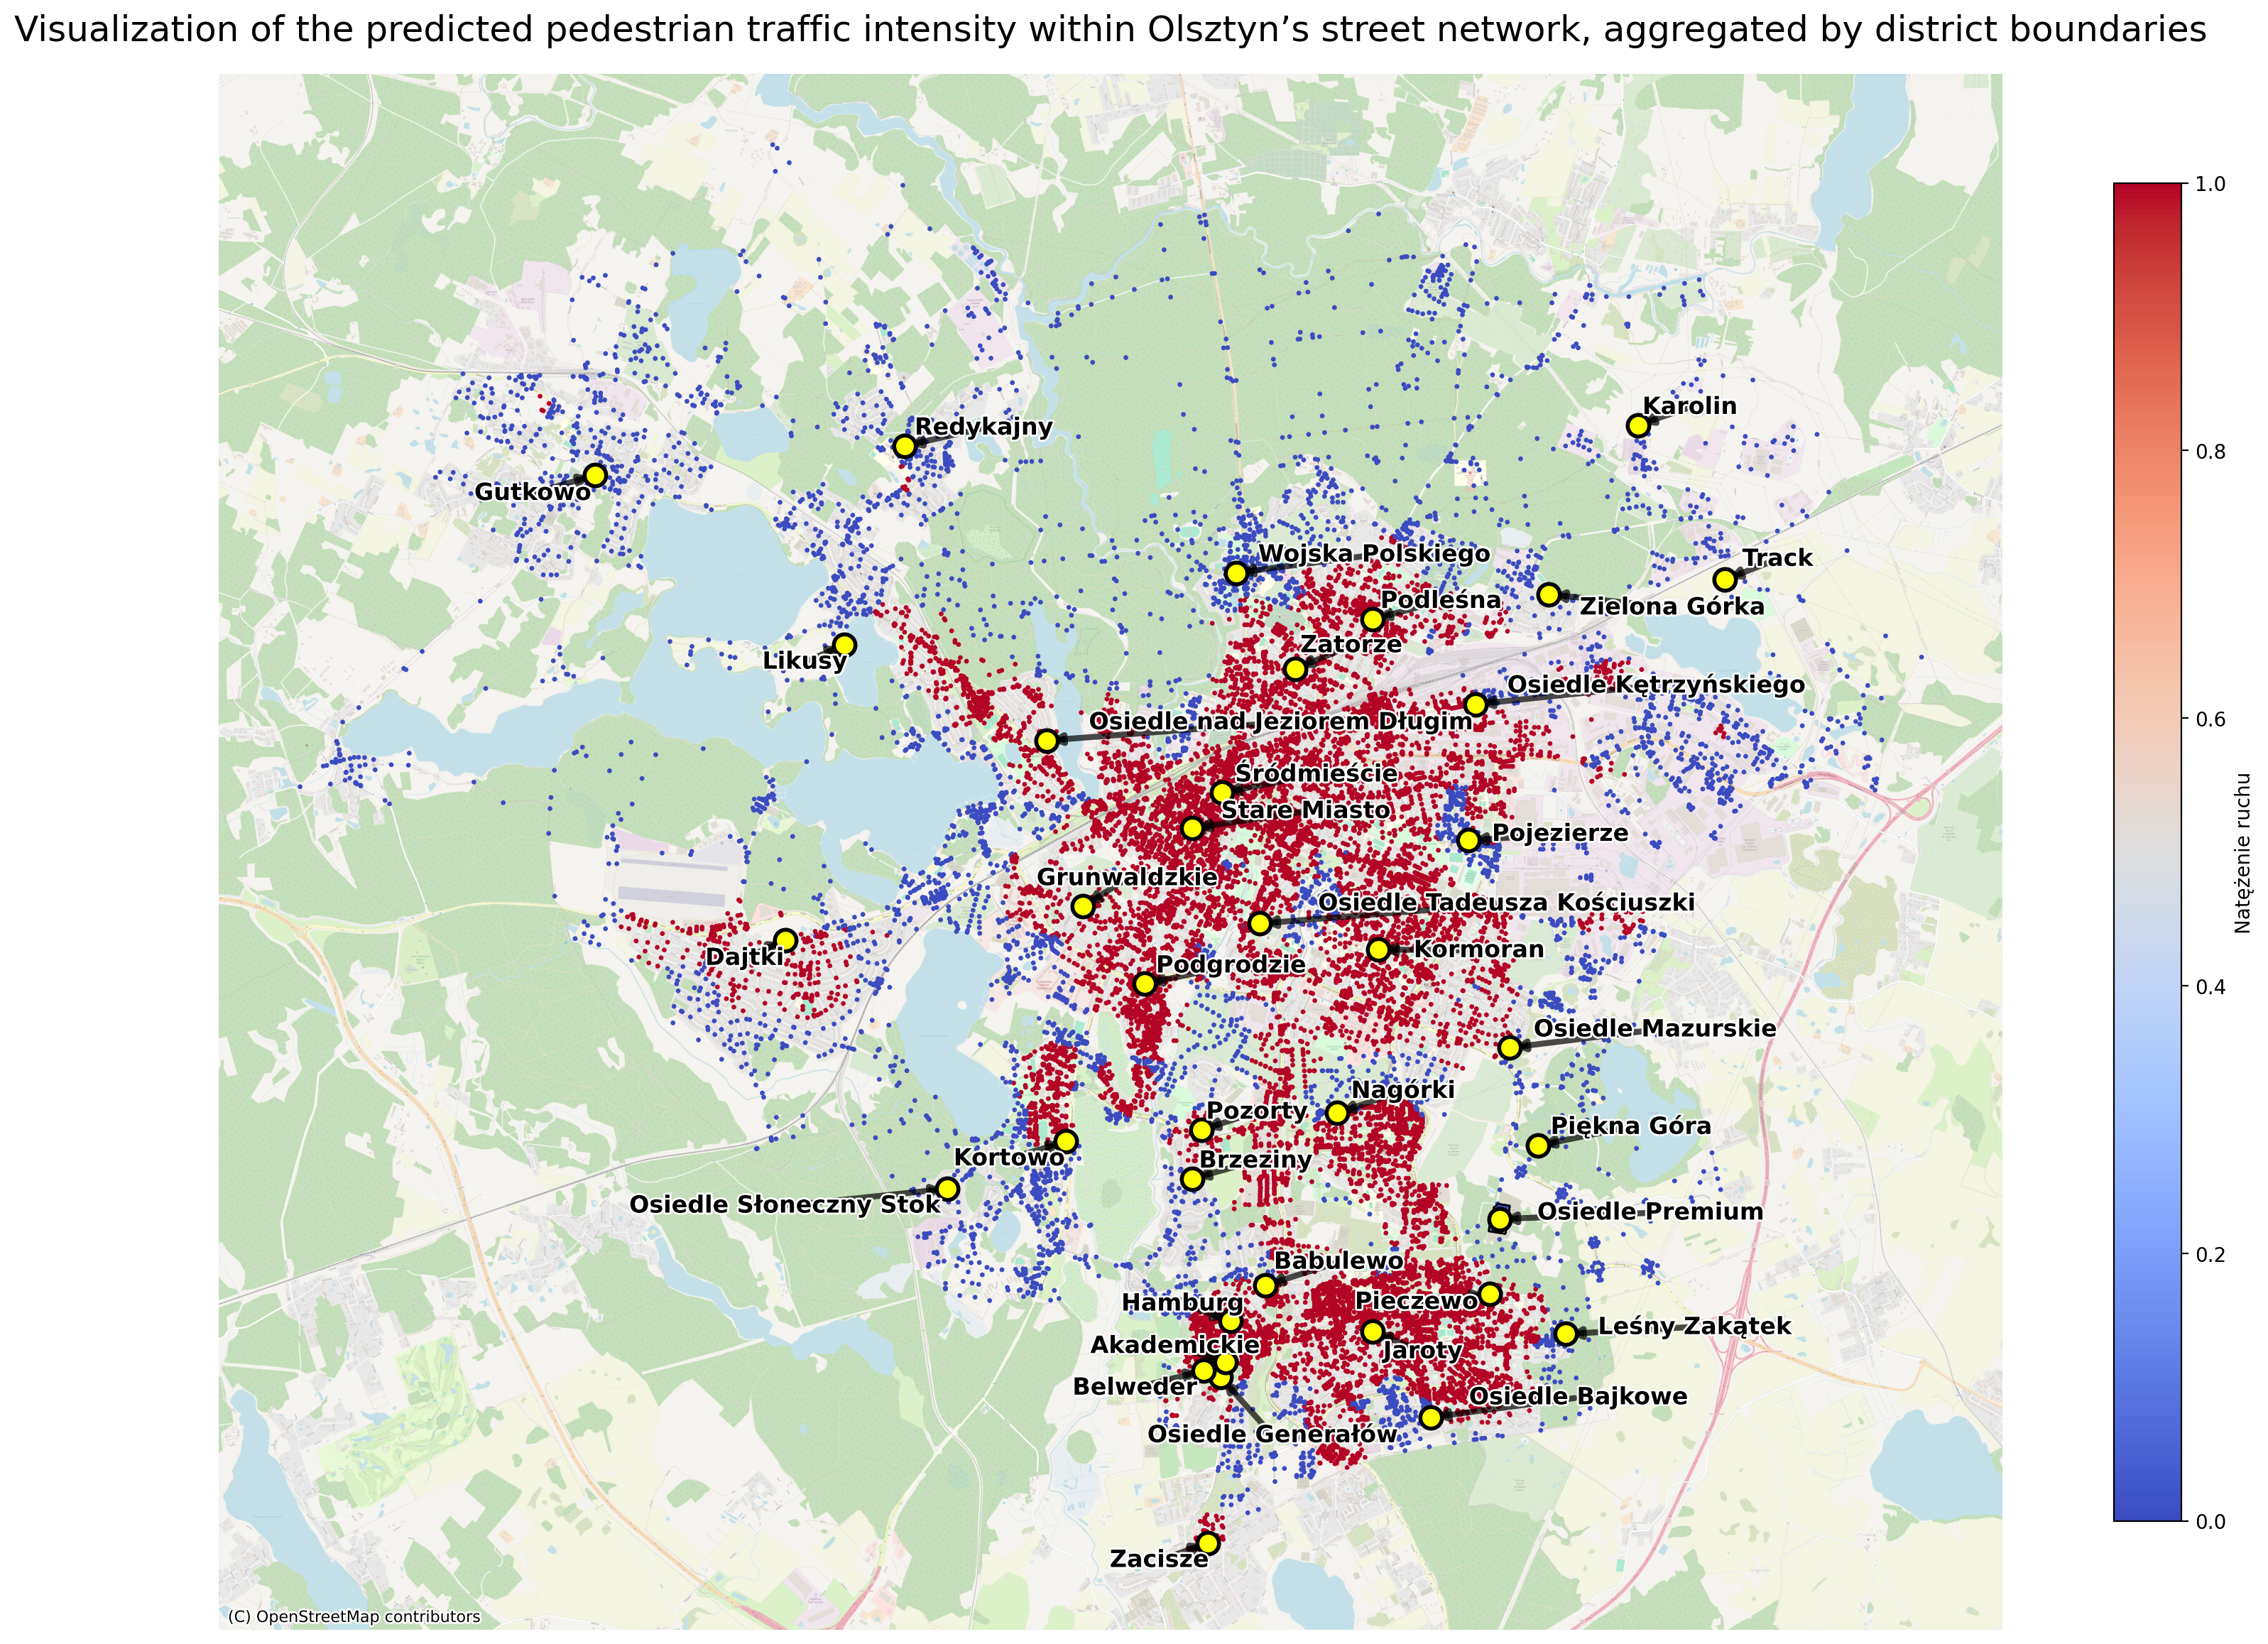

In [16]:
districts = districts.dropna(subset=["name"]).copy()
districts_unique = districts.drop_duplicates(subset="name").copy()
districts_unique['centroid'] = districts_unique.geometry.centroid

fig, ax = plt.subplots(figsize=(16, 16), dpi=200)

districts_unique.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1, alpha=0.7, zorder=2)
districts_unique.boundary.plot(ax=ax, color='black', linewidth=1, zorder=4)

nodes.plot(
    column="model_pred", ax=ax, cmap="coolwarm", legend=True,
    markersize=2, legend_kwds={'label': 'Natężenie ruchu', 'shrink': 0.6}, zorder=3
)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=16, alpha=0.7)

districts_unique.set_geometry('centroid').plot(
    ax=ax,
    markersize=120,
    color='yellow',
    marker='o',
    edgecolor='black',
    linewidth=2,
    zorder=10,
    alpha=1
)

texts = []
for idx, row in districts_unique.iterrows():
    x, y = row['centroid'].x, row['centroid'].y
    label = str(row['name'])
    txt = ax.text(
        x, y, label, fontsize=12, ha="center", va="center",
        color="black", weight="bold", zorder=20,
    )
    txt.set_path_effects([
        PathEffects.withStroke(linewidth=2, foreground='white')
    ])
    texts.append(txt)

adjust_text(
    texts, ax=ax,
    expand_points=(2.2, 2.2),
    arrowprops=dict(arrowstyle="-|>", color='black', lw=3, alpha=0.7)
)

ax.set_axis_off()
plt.title(
    "Visualization of the predicted pedestrian traffic intensity within Olsztyn’s street network, aggregated by district boundaries",
    fontsize=18
)
plt.tight_layout()
plt.show()

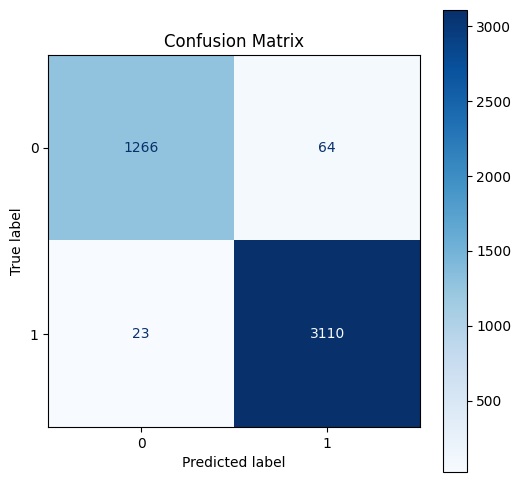

In [17]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

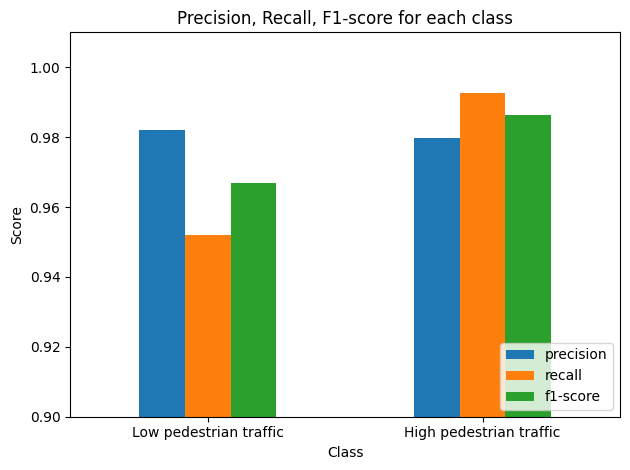

In [18]:
df_report = pd.DataFrame(classify_report).transpose()
df_report_classes = df_report.loc[['0', '1'], ['precision', 'recall', 'f1-score']]

df_report_classes.plot(kind='bar', ylim=(0.9, 1.01))
plt.title('Precision, Recall, F1-score for each class')
plt.ylabel('Score')
plt.xlabel('Class')
plt.xticks([0,1], ['Low pedestrian traffic', 'High pedestrian traffic'], rotation=0)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()